In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc_curve

<div class="alert alert-block alert-success">
<p>Read in the data</p>
</div>

In [2]:
rain = pd.read_csv('seattle_rain_train.csv')
print(rain.head())
rain.shape

DATE  PRCP  TMAX  TMIN  RAIN  TMIDR  TRANGE  MONTH  SEASON  \
0  1948-01-30  0.03    47    30     1   38.5      17      1       1   
1  1948-01-31  0.21    35    27     1   31.0       8      1       1   
2  1948-02-01  0.03    39    30     1   34.5       9      2       1   
3  1948-02-02  0.00    43    26     0   34.5      17      2       1   
4  1948-02-03  0.20    38    26     1   32.0      12      2       1   

   TMRW_RAIN  TMRW_PRCP  YEST_RAIN  YEST_PRCP  SUM7_PRCP  SUM14_PRCP  \
0        1.0       0.21        1.0       0.22       0.35        0.56   
1        1.0       0.03        1.0       0.03       0.46        0.77   
2        0.0       0.00        1.0       0.21       0.49        0.80   
3        1.0       0.20        1.0       0.03       0.49        0.80   
4        1.0       0.14        0.0       0.00       0.69        1.00   

   SUM30_PRCP  
0        4.28  
1        4.02  
2        3.46  
3        3.04  
4        2.93  


(18964, 16)

<div class="alert alert-block alert-success">
<p>Choose relevent features (Ignore ID, Date, and TMRW_PRCP)</p>
</div>

In [3]:
target = 'TMRW_RAIN'
features = ['PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']

<div class="alert alert-block alert-success">
<p>Split into train and validation set</p>
</div>

In [4]:
train_data, validation_data = train_test_split(rain, test_size=0.2)

<div class="alert alert-block alert-success">
<p>See what the majority class is and that we can see what we should be more accurate than.</p>
</div>

In [5]:
len(rain[rain['TMRW_RAIN'] == 1]) / len(rain)

0.42491035646488085

<div class="alert alert-block alert-success">
<p>The majority in TMRW_RAIN was 0, appearing 58% of the time. We should be more accurate than that.</p>
</div>

<div class="alert alert-block alert-success">
<h1>Random Forest Classifier</h1>
<p>Starting with Random Forest Classifier. Use GridSearch to find best hyperparameters (takes a bit of time)</p>
</div>

In [6]:
max_depth = [1] + np.arange(5, 16, 5).tolist()
min_samples_leaf = [1, 10, 50] + np.arange(100, 301, 100).tolist()

hyperparameters = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

search = GridSearchCV(estimator=RandomForestClassifier(), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10}


<div class="alert alert-block alert-success">
<p>Make graphs for accuracy of train and validation data</p>
</div>

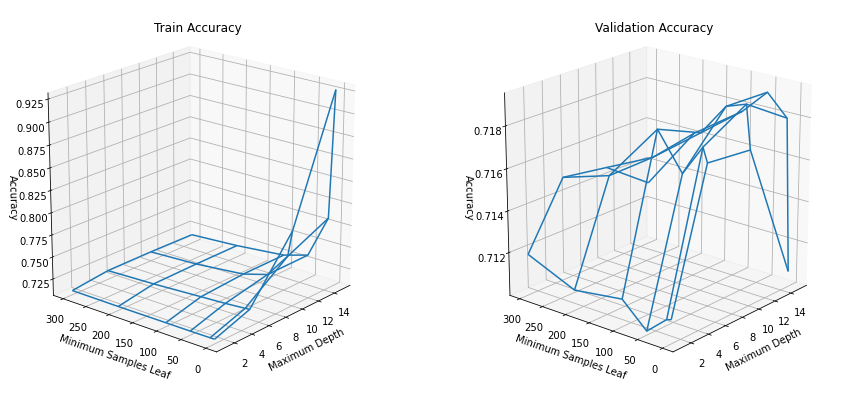

In [7]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

<div class="alert alert-block alert-success">
<p>Get accuracy score</p>
</div>

In [8]:
randomForest = RandomForestClassifier(max_depth=map['max_depth'], min_samples_leaf=map['min_samples_leaf'])
randomForest.fit(train_data[features], train_data[target])

predictions = randomForest.predict(validation_data[features])
print(accuracy_score(validation_data[target], predictions))

0.7213287635117321


<div class="alert alert-block alert-success">
<p>Get ROC Curve for Random Forest Classifier</p>
</div>

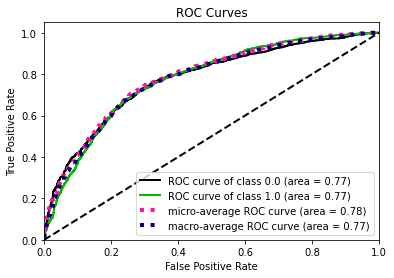

In [9]:
probabilities = randomForest.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>Logistic Regression</h1>
</div>

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L1 Regression</h2>
</div>

In [10]:
hyperparameters = {'penalty': ['l1'], 'C': [1/1, 1/4, 1/10, 1/1e2, 1/1e3, 1/1e5]}

search = GridSearchCV(estimator=LogisticRegression(fit_intercept=False, solver='liblinear'), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'C': 1.0, 'penalty': 'l1'}


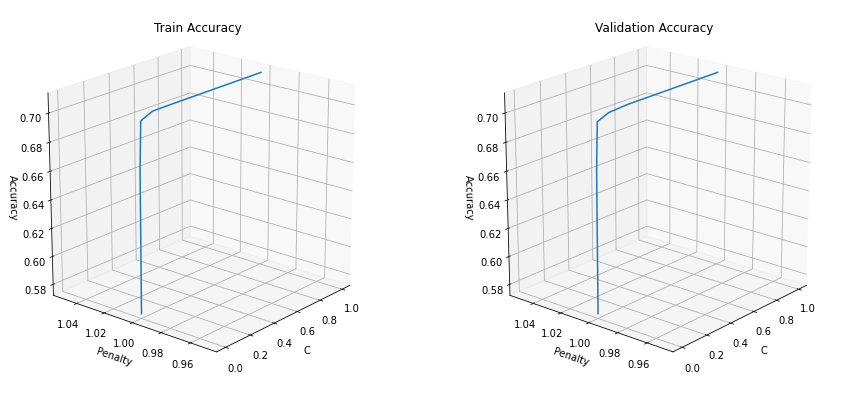

In [11]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['C']), len(hyperparameters['penalty'])))
    cs = cv_results['param_C'].reshape(scores.shape).data.astype(float)
    penalties = np.ma.asarray(np.array([1, 1, 1, 1, 1, 1])).reshape(scores.shape).data.astype(int)
    # penalties = cv_results['param_penalty'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(cs, penalties, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('C')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

In [12]:
l1_model = LogisticRegression(penalty='l1', C = 1/4, fit_intercept=False, solver='liblinear')
l1_model.fit(train_data[features], train_data[target])

predictions = l1_model.predict(validation_data[features])

weights = model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

accuracy_score(validation_data[target], predictions)

feature: PRCP, weight: 1.1813409527087149
feature: TMAX, weight: -0.0043571087174887994
feature: TMIN, weight: -0.003742386955388103
feature: RAIN, weight: 0.9762726502177004
feature: TMIDR, weight: -0.0018917397448322646
feature: TRANGE, weight: -0.04015815577876741
feature: MONTH, weight: 0.029094766809315362
feature: SEASON, weight: -0.11569493069017038
feature: YEST_RAIN, weight: 0.1335382816803397
feature: YEST_PRCP, weight: -0.04485310233310195
feature: SUM7_PRCP, weight: 0.09414111095625026
feature: SUM14_PRCP, weight: -0.014817973820753194
feature: SUM30_PRCP, weight: 0.07626604616034473


0.7115739520168732

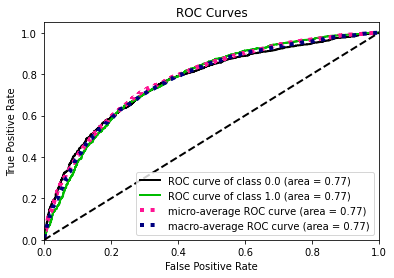

In [13]:
probabilities = l1_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L2 Regression</h2>
</div>

In [14]:
hyperparameters = {'penalty': ['l2'], 'C': [1/1, 1/4, 1/10, 1/1e2, 1/1e3, 1/1e5]}

search = GridSearchCV(estimator=LogisticRegression(fit_intercept=False), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'C': 1.0, 'penalty': 'l2'}


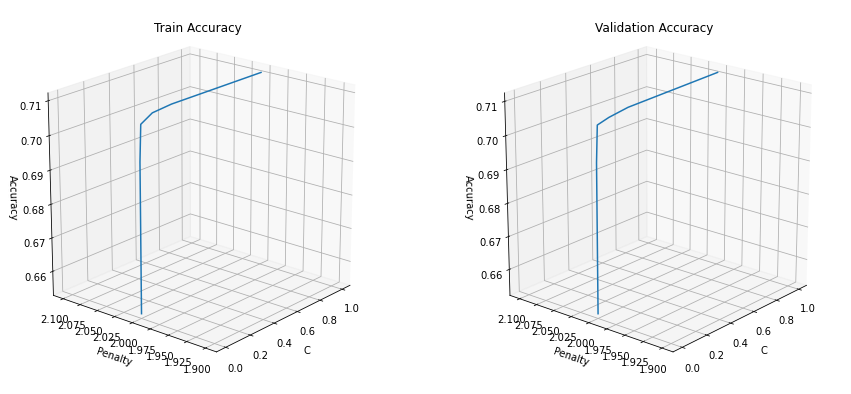

In [15]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['C']), len(hyperparameters['penalty'])))
    cs = cv_results['param_C'].reshape(scores.shape).data.astype(float)
    penalties = np.ma.asarray(np.array([2, 2, 2, 2, 2, 2])).reshape(scores.shape).data.astype(int)
    # penalties = cv_results['param_penalty'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(cs, penalties, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('C')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

In [16]:
l2_model = LogisticRegression(penalty='l2', C = 1/4, fit_intercept=False)
l2_model.fit(train_data[features], train_data[target])

predictions = l2_model.predict(validation_data[features])

weights = l2_model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

accuracy_score(validation_data[target], predictions)

feature: PRCP, weight: 0.6445570613578956
feature: TMAX, weight: -0.017867941026244522
feature: TMIN, weight: 0.012487962064007058
feature: RAIN, weight: 1.0589300951356444
feature: TMIDR, weight: -0.0026899894811337763
feature: TRANGE, weight: -0.030355903090269674
feature: MONTH, weight: 0.028680679296265194
feature: SEASON, weight: -0.12059275816074427
feature: YEST_RAIN, weight: 0.08202097083743899
feature: YEST_PRCP, weight: -0.04248865624863037
feature: SUM7_PRCP, weight: 0.13489731016057138
feature: SUM14_PRCP, weight: 0.022658813818522465
feature: SUM30_PRCP, weight: 0.05495993272891787


0.7115739520168732

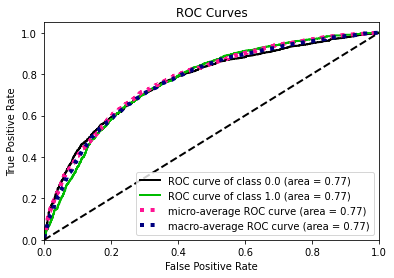

In [17]:
probabilities = l2_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h2>Random Forest with features from L2 Regression</h2>
</div>

In [18]:
model = LogisticRegression(penalty='l2', C = 1/1e3, fit_intercept=False)

model.fit(train_data[features], train_data[target])
weights = model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

feature: PRCP, weight: 0.1688283606020292
feature: TMAX, weight: -0.022891923572648725
feature: TMIN, weight: 0.02433261102820047
feature: RAIN, weight: 0.4394847351818461
feature: TMIDR, weight: 0.0007203437277800867
feature: TRANGE, weight: -0.04722453460085949
feature: MONTH, weight: -0.005060523010087552
feature: SEASON, weight: -0.020346820004050543
feature: YEST_RAIN, weight: 0.1127138630081227
feature: YEST_PRCP, weight: 0.021102858764164043
feature: SUM7_PRCP, weight: 0.12931440320895646
feature: SUM14_PRCP, weight: 0.029304057063557053
feature: SUM30_PRCP, weight: 0.091421615657481


In [19]:
new_features = []

for feature, weight in zip(features, weights):
    if (abs(weight) >= 0.01):
        new_features.append(feature)

print(new_features)

['PRCP', 'TMAX', 'TMIN', 'RAIN', 'TRANGE', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']


In [20]:
max_depth = [1] + np.arange(5, 16, 5).tolist()
min_samples_leaf = [1, 10, 50] + np.arange(100, 301, 100).tolist()

hyperparameters = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

search = GridSearchCV(estimator=RandomForestClassifier(), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[new_features], train_data[target])

print(search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 50}


In [21]:
randomForest = RandomForestClassifier(max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'])
randomForest.fit(train_data[new_features], train_data[target])

predictions = randomForest.predict(validation_data[new_features])
print(accuracy_score(validation_data[target], predictions))

0.7221196941734774


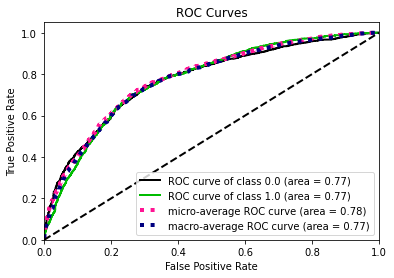

In [22]:
probabilities = randomForest.predict_proba(validation_data[new_features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

In [23]:
new_features.remove('SUM14_PRCP')
new_features.remove('SUM30_PRCP')

randomForest = RandomForestClassifier(max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'])
randomForest.fit(train_data[new_features], train_data[target])

predictions = randomForest.predict(validation_data[new_features])
print(accuracy_score(validation_data[target], predictions))

0.7173741102030056


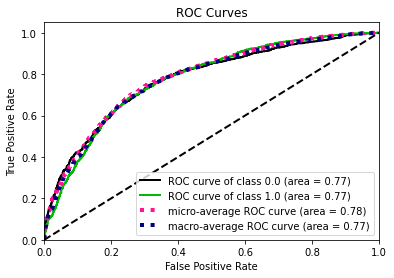

In [24]:
probabilities = randomForest.predict_proba(validation_data[new_features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>Get Prediction for Test</h1>
</div>

In [26]:
rain_test = pd.read_csv('seattle_rain_test.csv')

predictions = randomForest.predict(rain_test[new_features])

6557 6557


In [27]:
print(type(predictions))

<class 'numpy.ndarray'>


In [29]:
rain_test['Category'] = predictions

,Id,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,MONTH,SEASON,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP,Category
0,0,0.00,49,37,0,43.0,12,2,1,0.0,0.00,0.20,0.87,2.33,0.0
1,1,0.25,63,56,1,59.5,7,9,3,0.0,0.00,0.25,0.30,0.73,1.0
2,2,0.11,50,38,1,44.0,12,1,1,1.0,0.15,1.67,2.31,4.11,1.0
3,3,0.09,61,48,1,54.5,13,5,2,0.0,0.00,0.15,0.81,2.72,0.0
4,4,0.04,69,54,1,61.5,15,6,2,0.0,0.00,0.66,1.97,2.42,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,6552,0.00,75,58,0,66.5,17,6,2,0.0,0.00,0.08,0.37,1.09,0.0
6553,6553,0.00,52,35,0,43.5,17,3,1,1.0,0.02,1.71,3.91,8.84,0.0
6554,6554,0.00,29,14,0,21.5,15,11,4,0.0,0.00,0.42,1.25,4.80,0.0
6555,6555,0.00,83,57,0,70.0,26,8,3,0.0,0.00,0.28,0.28,0.28,0.0


In [30]:
type(rain_test)

pandas.core.frame.DataFrame

In [38]:
submission = rain_test[['Category', 'Id']]

In [39]:
submission.to_csv('submission.csv', index=False)